In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from statistics import mean 


This notebook is looking at forecasting the GMV from Direct to Customer products: 

In [51]:
# Load data
gmv_df = pd.read_csv('Desktop/gmv_by_product_type.csv')

In [52]:
# Extract year and week number
gmv_df['year'] = gmv_df['FL_WEEK_NUM'].astype(str).str[0:4]
gmv_df['week_num'] = gmv_df['FL_WEEK_NUM'].astype(str).str[4:6]
gmv_df.rename(columns={'FL_WEEK_NUM': 'fl_week_num', 'PRODUCT_TYPE' : 'product' , 'WEEKLY_GMV' : 'gmv' , 'NUM_TRANSACTIONS' : 'transactions' ,'year': 'year', 'week_num': 'week'}, inplace=True)

gmv_df['year'] = gmv_df['year'].astype(int)
gmv_df['week'] = gmv_df['week'].astype(int)

In [53]:
# Calculate cumulative transactions and GMV
gmv_df['cum_transactions'] = gmv_df.groupby(['product', 'year'])['transactions'].cumsum()
gmv_df['cum_gmv'] = gmv_df.groupby(['product', 'year'])['gmv'].cumsum()

In [54]:
##MicrocredentialProduct
##UpgradedAccessProduct
##PaidForCourseProduct
##ExpertTrackProduct
##UnlimitedAnnualProduct
##UnlimitedMonthlyProduct

In [55]:
# Analysis and prediction for MicrocredentialProduct
product_name = "UnlimitedAnnualProduct"
gmv_product = gmv_df[gmv_df['product'] == product_name]
gmv2022 = gmv_product[gmv_product['year'] == 2022]
gmv2023 = gmv_product[gmv_product['year'] == 2023]


In [56]:
current_week = gmv2023['week'].max()
x = 52 - current_week
gmv2023=gmv2023[gmv2023['week'] < current_week]

In [57]:
pred_week_num = np.arange(current_week, 53)
pred_type = ['predicted'] * (x + 1)
pred_year = [2023] * (x + 1)

In [58]:
gmv2023[gmv2023['product'] == product_name]['cum_gmv'].max()


586693.43

In [59]:
# Linear Regression Model
model = LinearRegression().fit(gmv2023[['week']], gmv2023['cum_gmv'])
slope = model.coef_[0]
intercept = gmv2023[gmv2023['product'] == product_name]['cum_gmv'].max()
pred_lm = np.arange(1, x + 2) * slope + intercept

lm_gmv = pd.DataFrame({'pred_year': pred_year, 'pred_week_num': pred_week_num, 'pred_lm': pred_lm, 'pred_type': pred_type})
lm_gmv['cum_lm_gmv'] = lm_gmv['pred_lm'].cumsum()

In [60]:
# Year-over-Year comparison

growth_from_2023 = gmv2022[gmv2022['week'] > current_week-1]['gmv'].cumsum()
pred_gmv = growth_from_2023 + gmv2023[gmv2023['product'] == product_name]['cum_gmv'].max()

################## Old Way to create the scaled forecast #####################
#ind_23=gmv2023[gmv2023['week'] == current_week-1].index[0]
#ind_22=gmv2022[gmv2022['week'] == current_week-1].index[0]
###YOY_comparison = gmv2023.loc[ind_23]['cum_gmv'] / gmv2022.loc[ind_22]['cum_gmv']
###scaled_pred_gmv = growth_from_2023 * YOY_comparison + gmv2023[gmv2023['product'] == product_name]['cum_gmv'].max()

################## New Way to create the scaled forecast #####################

# Find missing sequential integers
max_value = gmv2023['week'].max()
all_integers = set(range(1, max_value + 1))
existing_integers = set(gmv2023['week'])
missing_integers = sorted(all_integers - existing_integers)

# Add new rows for missing integers
if missing_integers:
    missing_rows = pd.DataFrame({'week': missing_integers})
    df = pd.concat([gmv2023, missing_rows]).sort_values('week').reset_index(drop=True)

else:
    df=gmv2023


# Extracting columns 'A' and 'B' into a new DataFrame
new_df = df[['week', 'gmv']].copy()

# Replacing NAs in column 'B' with 0
new_df['gmv'].fillna(0, inplace=True)

#GMV 2022

short_2022=gmv2022[gmv2022['week'] < current_week]
new_2022 = short_2022[['week', 'gmv']].copy()

##Finding the difference between the average weekly gmv between last year and this year. Numbers below 
#1 mean that this year is doing
##Better than last year i.e. if we get .7 then we have currently ~70% less than last year at this time, 
#and could expect our WOW model to do 70% worse, so we multiply the WOW growth from 2023 by this value 


YOY_comparison=mean(new_df['gmv'].values)/mean(new_2022['gmv'].values)
scaled_pred_gmv = growth_from_2023 * YOY_comparison + gmv2023[gmv2023['product'] == product_name]['cum_gmv'].max()



In [61]:
YOY_comparison

1.7121232553445214

In [62]:

pred_df = pd.DataFrame({'year': pred_year, 'week': pred_week_num, 'gmv': pred_gmv, 'type': pred_type})
scaled_pred_df = pd.DataFrame({'year': pred_year, 'week': pred_week_num, 'gmv': scaled_pred_gmv, 'type': pred_type})

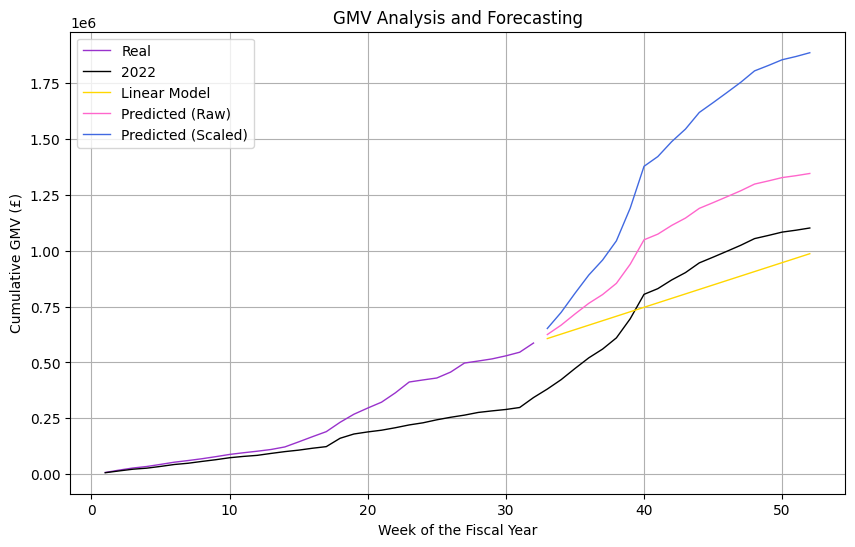

In [63]:
# Plotting GMV
plt.figure(figsize=(10, 6))
plt.plot(gmv2023['week'], gmv2023['cum_gmv'], color="darkorchid", linestyle='-', label="Real", linewidth=1)
plt.plot(gmv2022['week'], gmv2022['cum_gmv'], color="black", linestyle='-', label="2022", linewidth=1)
plt.plot(lm_gmv['pred_week_num'], lm_gmv['pred_lm'], color="gold", linestyle='-', label="Linear Model", linewidth=1)
plt.plot(pred_df['week'], pred_df['gmv'], color="#FF66CC", linestyle='-', label="Predicted (Raw)", linewidth=1)
plt.plot(scaled_pred_df['week'], scaled_pred_df['gmv'], color="royalblue", linestyle='-', label="Predicted (Scaled)", linewidth=1)
plt.xlabel('Week of the Fiscal Year')
plt.ylabel('Cumulative GMV (£)')
plt.title('GMV Analysis and Forecasting')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
print(gmv2023['gmv'].max())
print(max(pred_df['gmv']))
print(max(lm_gmv['pred_lm']))

48396.36
1345633.69
986569.2706891499


In [65]:
YOY_comparison

1.7121232553445214

In [32]:
gmv2023

,fl_week_num,product,gmv,transactions,year,week,cum_transactions,cum_gmv
313,202301,MicrocredentialProduct,16205.82,35,2023,1,35,16205.82
320,202302,MicrocredentialProduct,26358.58,52,2023,2,87,42564.40
326,202303,MicrocredentialProduct,21076.71,41,2023,3,128,63641.11
332,202304,MicrocredentialProduct,36583.09,87,2023,4,215,100224.20
336,202305,MicrocredentialProduct,39104.19,92,2023,5,307,139328.39
345,202306,MicrocredentialProduct,3150.16,8,2023,6,315,142478.55
349,202307,MicrocredentialProduct,4327.16,8,2023,7,323,146805.71
356,202308,MicrocredentialProduct,6399.72,11,2023,8,334,153205.43
360,202309,MicrocredentialProduct,7276.27,13,2023,9,347,160481.70
371,202310,MicrocredentialProduct,5501.61,10,2023,10,357,165983.31
